# Oversampling

In [1]:
import numpy as np

# tSNE visualization

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np


def tsne_visualization(minority, minority_generated, name):

    sns.set_style("darkgrid")

    # Combine all data into one dataset
    combined_data = np.concatenate((minority, minority_generated))

    # Create labels for the data
    labels = np.array(['Original'] * len(minority) + ['Synthetic'] * len(minority_generated))

    # Perform t-SNE
    tsne = TSNE(n_components=2,learning_rate='auto', init='random', perplexity=40)
    tsne_results = tsne.fit_transform(combined_data)

    # Plotting
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=tsne_results[:, 0], y=tsne_results[:, 1], 
        hue=labels, 
        palette=['red', 'blue'],
        alpha=0.2,
        s=15
    )
    
    plt.title('t-SNE plot of SWAN-SF Dataset (Partition 1) with ' + name, fontsize=10)


    plt.xlabel('t-SNE Feature 1')
    plt.ylabel('t-SNE Feature 2')
    
    plt.savefig(name+'.svg')

    plt.legend(loc='best')
    plt.show()


## Smote and Adasyn

In [3]:
# SMOTE
# ADASYN
from imblearn.over_sampling import SMOTE, ADASYN

def smote_adasyn(start_position, end_position, data_dir, name, X_train, Y_train):

    for i in range(start_position-1, end_position):
        
        class_counts = np.bincount(Y_train[i].astype(int))
        minority_class = np.argmin(class_counts)
        minority_indices = np.where(Y_train[i] == minority_class)[0]
                
        smote = SMOTE(sampling_strategy='minority', random_state=42)
        X_train_Smote, Y_train_Smote = smote.fit_resample(X_train[i], Y_train[i])

        adasyn = ADASYN(sampling_strategy='minority', random_state=42)
        X_train_Adasyn, Y_train_Adasyn = adasyn.fit_resample(X_train[i], Y_train[i])

        print('Partition' + str(i+1) + ': ')
        print(X_train_Smote.shape)
        print(Y_train_Smote.shape)
        print(X_train_Adasyn.shape)
        print(str(Y_train_Adasyn.shape) + '\n')
        
        
        #tSNE
        if i == 0:
            original = X_train[i][minority_indices]
            length = X_train[i].shape[0]
            synthetic = X_train_Smote[length:length+original.shape[0],:]
            tsne_visualization(original[:,300:360], synthetic[:,300:360], 'Smote')
        
        num_samples = X_train_Smote.shape[0]
        shuffle_indices = np.random.permutation(num_samples)

        X_train_Smote_shuffled = X_train_Smote[shuffle_indices]
        Y_train_Smote_shuffled = Y_train_Smote[shuffle_indices]
    
        with open(data_dir + "Smote" + "_Partition" + str(i+1) 
                       + "_" + name + ".pkl", 'wb') as f:
            pickle.dump(X_train_Smote_shuffled, f)

        with open(data_dir + "Smote" + "_Partition" + str(i+1) 
                       + "_Labels_" + name + ".pkl", 'wb') as f:
            pickle.dump(Y_train_Smote_shuffled, f)
            
        
        #tSNE
        if i == 0:
            original = X_train[i][minority_indices]
            length = X_train[i].shape[0]
            synthetic = X_train_Adasyn[length:length+original.shape[0],:]
            tsne_visualization(original[:,300:360], synthetic[:,300:360], 'Adasyn')
        
        num_samples = X_train_Adasyn.shape[0]
        shuffle_indices = np.random.permutation(num_samples)

        X_train_Adasyn_shuffled = X_train_Adasyn[shuffle_indices]
        Y_train_Adasyn_shuffled = Y_train_Adasyn[shuffle_indices]
    
        with open(data_dir + "Adasyn" + "_Partition" + str(i+1) 
                       + "_" + name + ".pkl", 'wb') as f:
            pickle.dump(X_train_Adasyn_shuffled, f)

        with open(data_dir + "Adasyn" + "_Partition" + str(i+1) 
                       + "_Labels_" + name + ".pkl", 'wb') as f:
            pickle.dump(Y_train_Adasyn_shuffled, f)



## Gaussian Noise Injection

In [4]:
import numpy as np
import pickle

def gni(start_position, end_position, data_dir, name, X_train, Y_train, noise_proportion=0.05):
    for i in range(start_position-1, end_position):
        
        std_dev = np.std(X_train[i], axis=0)
        noise_level = std_dev * noise_proportion

        class_counts = np.bincount(Y_train[i].astype(int))
        max_class_count = np.max(class_counts)
        minority_class = np.argmin(class_counts)
        num_samples_to_add = max_class_count - class_counts[minority_class]

        minority_indices = np.where(Y_train[i] == minority_class)[0]

        new_samples = []
        for _ in range(num_samples_to_add):
            # Randomly select a minority sample
            sample_index = np.random.choice(minority_indices)
            sample = X_train[i][sample_index]

            # Add Gaussian noise
            noise = np.random.normal(0, noise_level, sample.shape)
            new_sample = sample + noise
            new_samples.append(new_sample)

        # Append new samples to the training set
        X_train_augmented = np.vstack((X_train[i], new_samples))
        Y_train_augmented = np.append(Y_train[i], np.full(num_samples_to_add, minority_class))
        
        
        print('Partition' + str(i+1) + ': ')
        print(X_train_augmented.shape)
        print(str(Y_train_augmented.shape) + '\n')
        
        #tSNE
        if i == 0:
            original = X_train[i][minority_indices]
            new_samples = np.array(new_samples)
            synthetic = new_samples[0:original.shape[0],:]
            indices = [0, 120, 240, 300]
            tsne_visualization(original[:,300:360], synthetic[:,300:360], 'GNI')

        # Shuffle the augmented dataset
        shuffle_indices = np.random.permutation(len(Y_train_augmented))
        X_train_augmented = X_train_augmented[shuffle_indices]
        Y_train_augmented = Y_train_augmented[shuffle_indices]

        # Save the augmented data
        with open(data_dir + "GaussianNoise" + "_Partition" + str(i+1) + "_" + name + ".pkl", 'wb') as f:
            pickle.dump(X_train_augmented, f)

        with open(data_dir + "GaussianNoise" + "_Partition" + str(i+1) + "_Labels_" + name + ".pkl", 'wb') as f:
            pickle.dump(Y_train_augmented, f)


## TimeGan (state-of-the-art)

In [3]:
import numpy as np
import pickle
from timegan import timegan

def timegan_oversamping(start_position, end_position, data_dir, name, X_train, Y_train):
    # TimeGAN network parameters
    parameters = dict()
    parameters['module'] = 'gru'
    parameters['hidden_dim'] = 24
    parameters['num_layer'] = 3
    parameters['iterations'] = 6000
    parameters['batch_size'] = 128

    for i in range(start_position-1, end_position):
        # Identify the minority class
        class_counts = np.bincount(Y_train[i].astype(int))
        minority_class = np.argmin(class_counts)
        majority_class = np.argmax(class_counts)

        # Extract samples belonging to the minority and majority classes
        minority_indices = np.where(Y_train[i] == minority_class)[0]
        majority_indices = np.where(Y_train[i] == majority_class)[0]
        minority_class_data = X_train[i][minority_indices]
        majority_class_data = X_train[i][majority_indices]
        
        num_of_data_to_be_generated = majority_class_data.shape[0] - minority_class_data.shape[0]

        # Run TimeGAN for synthetic data generation on minority class data
        generated_data = timegan(minority_class_data, parameters, num_of_data_to_be_generated)

        # Combine original minority data with generated data
        X_train_minority_augmented = np.vstack((minority_class_data, generated_data))

        # Update labels for generated data
        num_generated_samples = len(generated_data)
        Y_train_minority_augmented = np.append(np.full(len(minority_class_data), minority_class),
                                               np.full(num_generated_samples, minority_class))

        # Combine majority class data with augmented minority class data
        X_train_augmented = np.vstack((majority_class_data, X_train_minority_augmented))
        Y_train_augmented = np.append(Y_train[i][majority_indices], Y_train_minority_augmented)
        
        num_timestamps = 60
        num_attributes = 24
        new_partition = np.zeros((np.array(X_train_augmented).shape[0], num_timestamps*(num_attributes)))        
        
        for j in range(0,new_partition.shape[0]):
            new_column = np.zeros((num_timestamps,num_attributes)) 
            new_column = X_train_augmented[j,:,:]

            flettened = np.zeros(num_timestamps*(num_attributes))

            for m in range(0,num_attributes):
                flettened[(m)*num_timestamps:(m+1)*num_timestamps] = new_column[:,m]

            new_partition[j,:] = flettened
                
                
        #tSNE
        if i == 0:
            original = X_train[i][minority_indices]
            new_samples = np.array(generated_data)
            synthetic = new_samples[0:original.shape[0],:,6]
            tsne_visualization(original[:,:,6], synthetic, 'TimeGAN')
        
        print('Partition' + str(i+1) + ': ')
        print(new_partition.shape)
        print(str(Y_train_augmented.shape) + '\n')

        # Shuffle the augmented dataset
        shuffle_indices = np.random.permutation(len(Y_train_augmented))
        X_train_augmented = new_partition[shuffle_indices]
        Y_train_augmented = Y_train_augmented[shuffle_indices]

        # Save the augmented data
        with open(data_dir + "TimeGAN" + "_Partition" + str(i+1) + "_" + name + ".pkl", 'wb') as f:
            pickle.dump(X_train_augmented, f)

        with open(data_dir + "TimeGAN" + "_Partition" + str(i+1) + "_Labels_" + name + ".pkl", 'wb') as f:
            pickle.dump(Y_train_augmented, f)

In [4]:
import pickle
import pandas as pd

data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/4_4_FinalData_WithoutC_Concatenation_KnnImputation/"

X_train_array = []
Y_train_array = []

num_partitions = 5
for i in range(0, num_partitions):
    with open(data_dir + "Partition" + str(i+1) + "_WithoutC_Concatenation_KnnImputation" +".pkl", 'rb') as f:
        X_train_array.append(pickle.load(f))
    with open(data_dir + "Partition" + str(i+1) + "_Labels_WithoutC_Concatenation_KnnImputation" +".pkl", 'rb') as f:
        Y_train_array.append(pickle.load(f))
        


Partition1: 
(131644, 1440)
(131644,)
(131540, 1440)
(131540,)



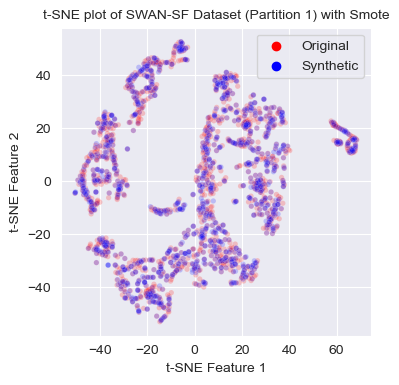

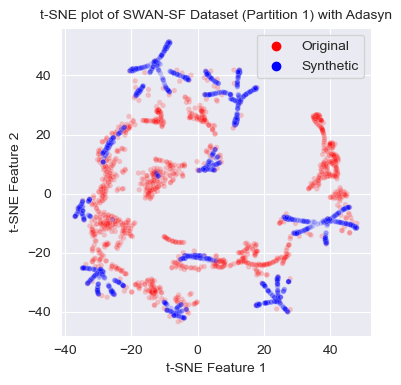

Partition2: 
(156692, 1440)
(156692,)
(156622, 1440)
(156622,)

Partition3: 
(70894, 1440)
(70894,)
(70907, 1440)
(70907,)

Partition4: 
(88280, 1440)
(88280,)
(88334, 1440)
(88334,)

Partition5: 
(137224, 1440)
(137224,)
(137253, 1440)
(137253,)



In [7]:
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/\
6_2_OSampling_Concatenation_KnnImputation/"

name = "OSampling_WithoutC_Concatenation_KnnImputation"

smote_adasyn(1, 5, data_dir, name, X_train_array, Y_train_array)

Partition1: 
(131644, 1440)
(131644,)



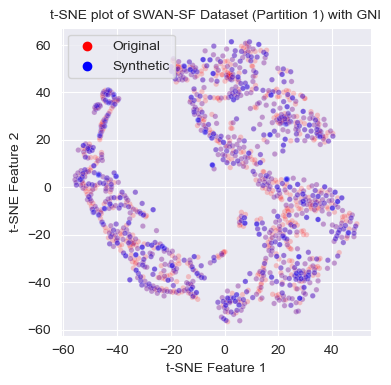

Partition2: 
(156692, 1440)
(156692,)

Partition3: 
(70894, 1440)
(70894,)

Partition4: 
(88280, 1440)
(88280,)

Partition5: 
(137224, 1440)
(137224,)



In [8]:
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/\
6_2_OSampling_Concatenation_KnnImputation/"

name = "OSampling_WithoutC_Concatenation_KnnImputation"

gni(1, 5, data_dir, name, X_train_array, Y_train_array)

In [5]:
num_attributes = 24
num_partitions = 5
num_timestamps = 60
X_train_concat_ZM_3D = []
for i in range(0, num_partitions):
    new_3D = np.zeros((X_train_array[i].shape[0], num_timestamps, num_attributes))

    for j in range(0, X_train_array[i].shape[0]):
        for m in range(0, num_attributes):
            new_3D[j,:,m] = X_train_array[i][j,m*num_timestamps:(m+1)*num_timestamps]
    X_train_concat_ZM_3D.append(new_3D)

In [6]:
del X_train_array

In [ ]:
data_dir = "/Users/samskanderi/Documents/Research_Project/SWANSF/code/\
6_2_OSampling_Concatenation_KnnImputation/"

name = "OSampling_WithoutC_Concatenation_KnnImputation"

timegan_oversamping(1, 5, data_dir, name, X_train_concat_ZM_3D, Y_train_array)

Start Embedding Network Training
step: 0/6000, e_loss: 0.2475
step: 1000/6000, e_loss: 0.0453
step: 2000/6000, e_loss: 0.0332
step: 3000/6000, e_loss: 0.0278
step: 4000/6000, e_loss: 0.0251
step: 5000/6000, e_loss: 0.0245
Finish Embedding Network Training
Start Training with Supervised Loss Only
step: 0/6000, s_loss: 0.2826
step: 1000/6000, s_loss: 0.0235
step: 2000/6000, s_loss: 0.0166
step: 3000/6000, s_loss: 0.0145
step: 4000/6000, s_loss: 0.0116
step: 5000/6000, s_loss: 0.0103
Finish Training with Supervised Loss Only
Start Joint Training
step: 0/6000, d_loss: 2.0579, g_loss_u: 0.7109, g_loss_s: 0.0163, g_loss_v: 0.2549, e_loss_t0: 0.059
step: 1000/6000, d_loss: 0.9475, g_loss_u: 2.4441, g_loss_s: 0.019, g_loss_v: 0.0918, e_loss_t0: 0.02
step: 2000/6000, d_loss: 0.9383, g_loss_u: 2.6268, g_loss_s: 0.0275, g_loss_v: 0.112, e_loss_t0: 0.0188
step: 3000/6000, d_loss: 0.5974, g_loss_u: 2.3231, g_loss_s: 0.1571, g_loss_v: 0.2467, e_loss_t0: 0.0172
step: 4000/6000, d_loss: 0.6461, g_loss